# 1. Convert the images from the 4-class dog dataset to edge histograms. (You should have donethis in Assignment 2) and normalize the histogram dataset.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from pathlib import Path
from skimage.color import rgb2gray
from skimage import io, exposure, filters
import glob


myBreeds = [
    "n02099712-Labrador_retriever",
    "n02110185-Siberian_husky",
    "n02113799-standard_poodle",
    "n02113186-Cardigan"
 ]


class AllRequiredPaths:
    root_dir = ""
    imgs_folder = ""
    imgs_folder_sub_folders = [f"images/{name}" for name in myBreeds]
    
    def __init__(self):
        self.root_dir = os.getcwd()
        self.imgs_folder = os.path.join(self.root_dir, "images")

all_paths = AllRequiredPaths()

# 1. Get all the image of four classes
breeds_images = [str(image_path) for breed_path in all_paths.imgs_folder_sub_folders for image_path in Path(os.path.join(all_paths.root_dir, breed_path)).glob("*.jpg")]
 
breeds_labels = [ i for i, breed_path in enumerate(all_paths.imgs_folder_sub_folders) for _ in Path(os.path.join(all_paths.root_dir, breed_path)).glob("*.jpg")]
 
#2. Convert the images to edge histograms.
class EdgeHistogramAnalysis:
    def __init__(self, all_images):
        self.all_paths = AllRequiredPaths()
        self.all_images = all_images
        
    def _angle(self, dx, dy):
        return np.mod(np.arctan2(dy, dx), np.pi)
        
    def show_result(self):
        histograms = []
        for image_path in self.all_images:
            img = io.imread(image_path)
            grayscale_img = rgb2gray(img)
            dx = filters.sobel_h(grayscale_img)
            dy = filters.sobel_v(grayscale_img)
            ang = self._angle(dx, dy)
            hist, _ = exposure.histogram(ang, nbins=36, source_range='dtype')
            histograms.append(hist)
            
        return np.array(histograms)
            
            
edge_hist_analysis = EdgeHistogramAnalysis(breeds_images)
histograms = edge_hist_analysis.show_result()
print(histograms)

[[   0    0    0 ... 3111 3253 3169]
 [   0    0    0 ... 3791 3902 3861]
 [   0    0    0 ... 3009 3106 3246]
 ...
 [   0    0    0 ... 1501 1859 2281]
 [   0    0    0 ... 1590 1851 2300]
 [   0    0    0 ... 2115 2209 2187]]


In [8]:
from sklearn.preprocessing import StandardScaler
standar_scaler = StandardScaler()
n_hist = standar_scaler.fit_transform(histograms)
n_hist

array([[ 0.        ,  0.        ,  0.        , ...,  0.49035446,
         0.54510787,  0.37416599],
       [ 0.        ,  0.        ,  0.        , ...,  1.06526012,
         1.09020085,  0.94386714],
       [ 0.        ,  0.        ,  0.        , ...,  0.40411861,
         0.42164305,  0.43755759],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.87081922,
        -0.62570818, -0.35689561],
       [ 0.        ,  0.        ,  0.        , ..., -0.79557422,
        -0.63242735, -0.34125352],
       [ 0.        ,  0.        ,  0.        , ..., -0.35171323,
        -0.33174432, -0.43428276]])

# 2. Perform dimension reduction on your new dog image representation dataset to reduce the dimension to 2 (similar to Assignment 1 Question 2(f))

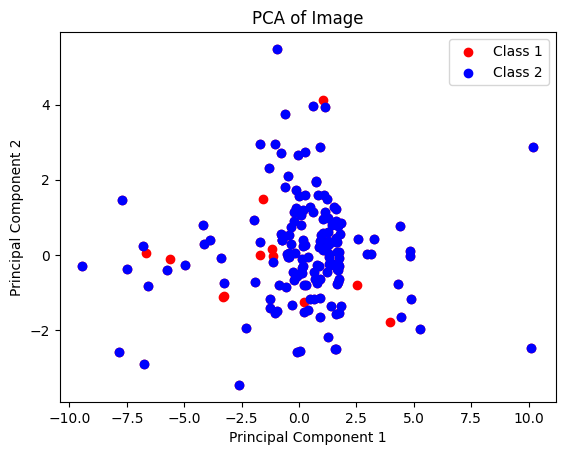

In [50]:
from sklearn.decomposition import PCA

class PCAAnalysis:
    def __init__(self):
        self.all_paths = AllRequiredPaths()

    def _angle(self, dx, dy):
        return np.mod(np.arctan2(dx,dy), np.pi)
        
    def _edge_histogram(self, image):
        gray_img = color.rgb2gray(image)
        angles = self._angle(filters.sobel_h(gray_img), filters.sobel_v(gray_img))
        hist, _ = np.histogram(angles, bins=36, range=(-np.pi, np.pi))
        return hist

    def fetch_images(self, folder_name):
        allImage = []
        for img_name in os.listdir(folder_name):
            if img_name.lower().endswith(".jpg"):
                allImage.append(os.path.join(folder_name, img_name))
        return allImage

    def perform_pca_and_show_result(self, class1, class2):
        hists = []
        labels = []
        classes = class1 + class2

        for img_path in classes:
            img = io.imread(img_path)
            hist = self._edge_histogram(img)
            hists.append(hist)
            labels.append("Class 1" if img_path in class1 else "Class 2")

        histogram = np.array(hists)
        
        std_scalar = StandardScaler()
        hist_std = std_scalar.fit_transform(histogram)

        pca = PCA(n_components=2)
        hist_pca = pca.fit_transform(hist_std)

        pca1 = hist_pca[:len(class1)]
        pca2 = hist_pca[:len(class2)]

        plt.scatter(pca1[:, 0], pca1[:, 1], color = "red", label = "Class-1")
        plt.scatter(pca2[:, 0], pca2[:, 1], color = "blue", label = "Class-2")

        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(["Class 1", "Class 2"])
        plt.title("PCA of Image")
        plt.show()

        return hist_pca, labels


pca_analysis = PCAAnalysis()
pca1_folder = pca_analysis.fetch_images(f"images/{myBreeds[0]}")
pca2_folder = pca_analysis.fetch_images(f"images/{myBreeds[2]}")

reduced_histograms, labels =  pca_analysis.perform_pca_and_show_result(pca1_folder, pca2_folder)

# 3. Perform clustering using the following approaches on the 2D dataset you
preprocessed in Item 2:
• K-mean clustering and its variants for 𝐾 = 4:
(a) K-means clustering: (Use KMeans with init = ‘Random’) (0.5 point)
(b) KMeans with init=‘k-means++’ (0.5 point)
(c) Bisecting K-means (sklearn.cluster.BisectingKMeans with init = ‘Random’) (0.5 point)
(d) spectral clustering (sklearn.cluster.SpectralClustering with default parameters) (0.5 point)
• DBSCAN (0.5 point)
– What are the eps and min samples parameter values you used to get 4 clusters? (0.5
point)
+ Agglomerative clustering (i.e., hierarchical clustering) - use sklearn.cluster.AgglomerativeClustering
with number of clusters set to 4
(a) Single link (MIN), (0.5 point)
(b) Complete link (MAX), (0.5 point)
(c) Group Average, and (0.5 point)
(d) Ward’s method (0.5 point)
Use the four linkage values ‘ward’, ‘complete’, ‘average’, ‘single’ for sklearn.cluster.
AgglomerativeClustering

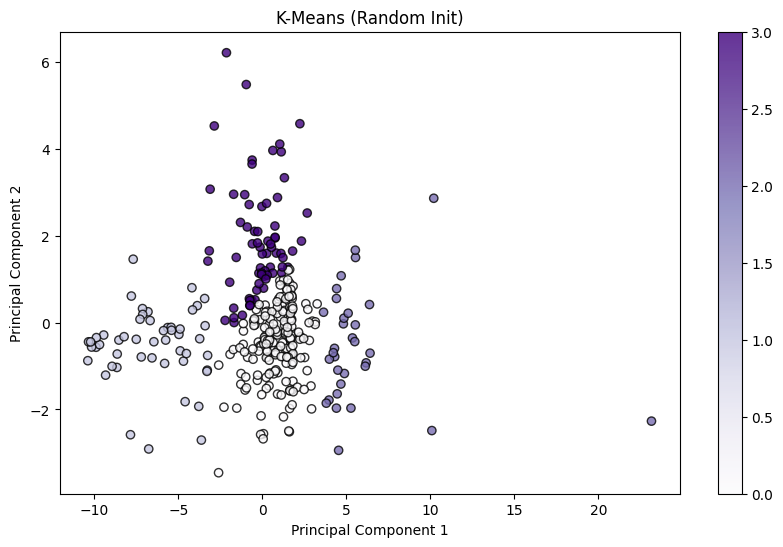

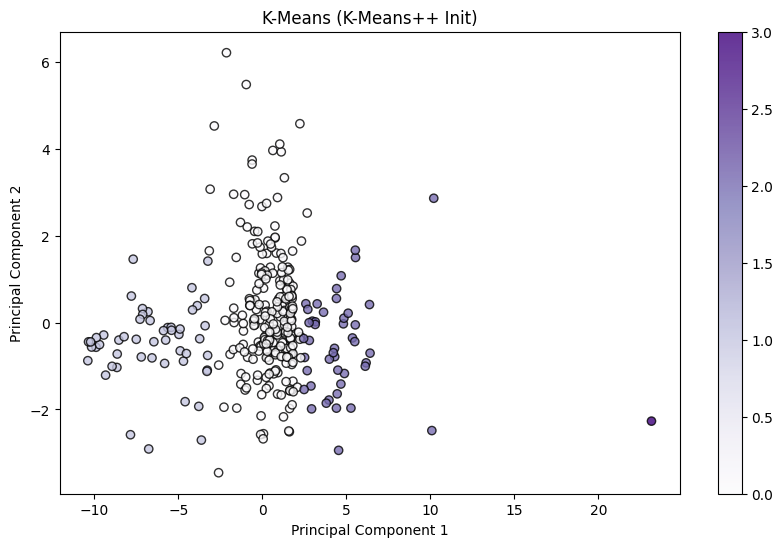

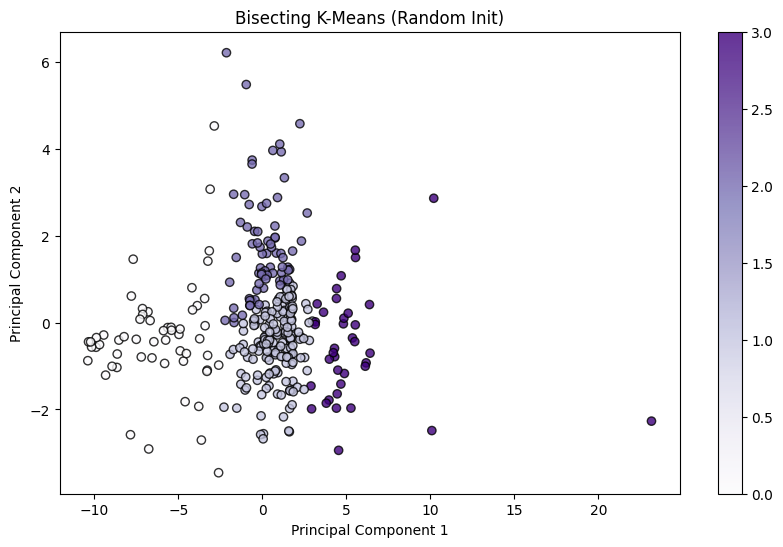

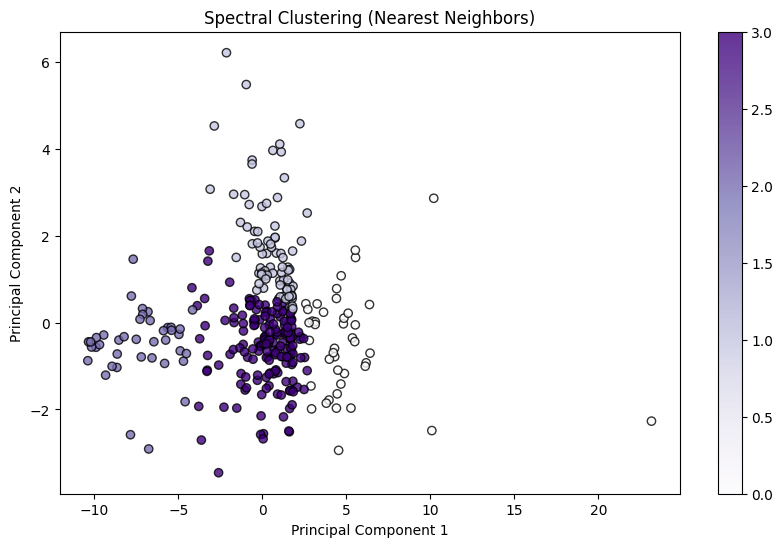

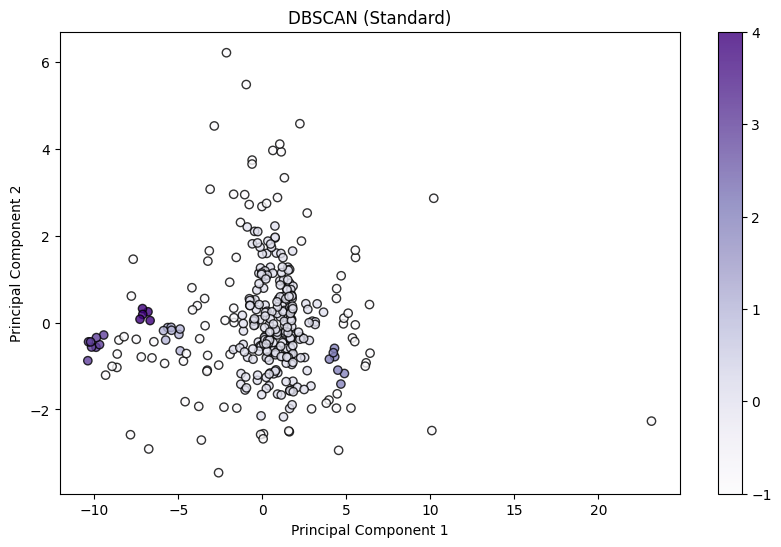

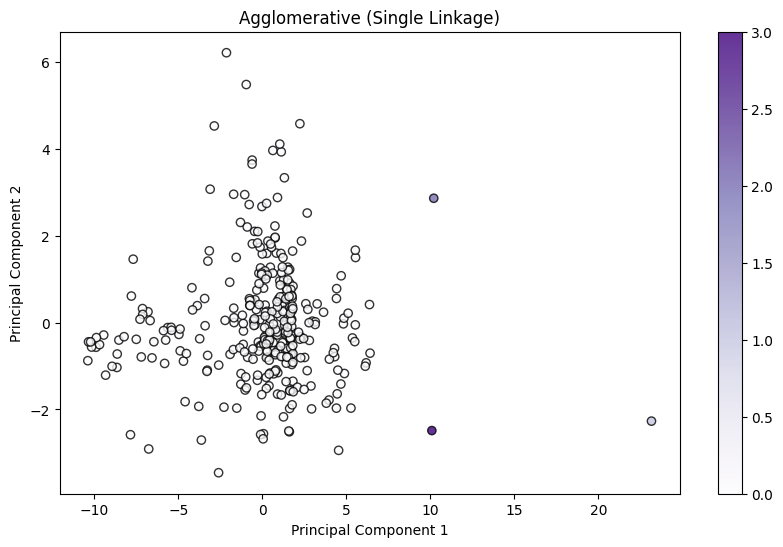

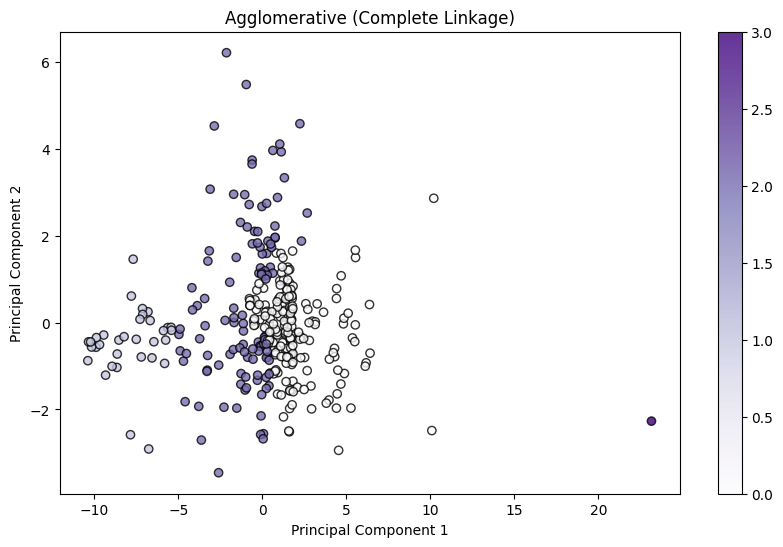

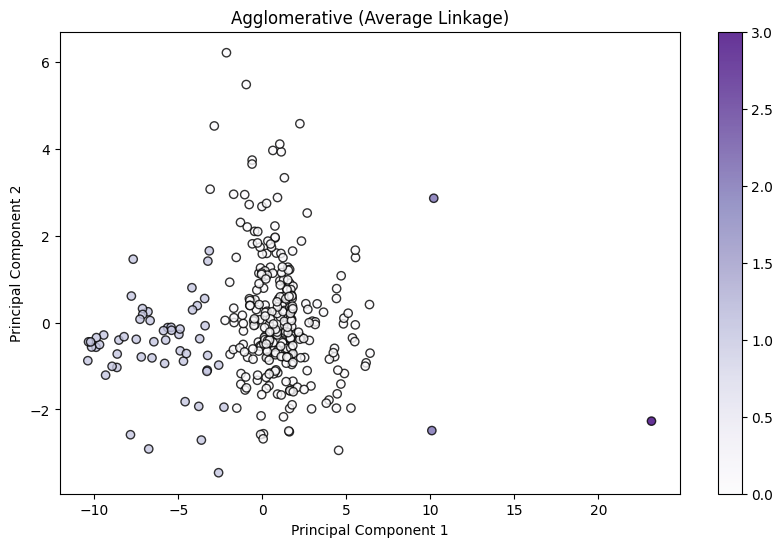

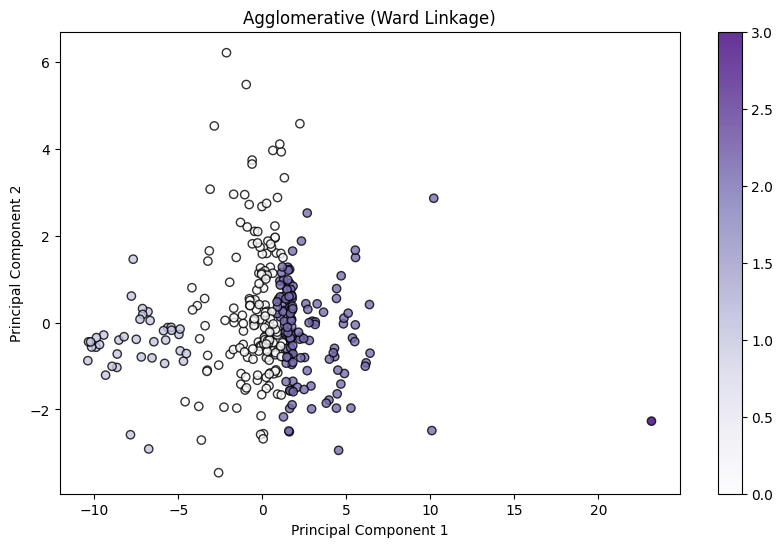

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering, SpectralClustering, DBSCAN

class DataClusterer:
    def __init__(self, data):
        self.data = data
        self.num_clusters = 4
        self.cluster_methods = self.initialize_clustering_methods()

    def initialize_clustering_methods(self):
        return {
            'K-Means (Random Init)': KMeans(n_clusters=self.num_clusters, init='random', n_init=10, random_state=42),
            'K-Means (K-Means++ Init)': KMeans(n_clusters=self.num_clusters, init='k-means++', n_init=10, random_state=42),
            'Bisecting K-Means (Random Init)': BisectingKMeans(n_clusters=self.num_clusters, init='random', random_state=42),
            'Spectral Clustering (Nearest Neighbors)': SpectralClustering(n_clusters=self.num_clusters, random_state=42, affinity='nearest_neighbors'),
            'DBSCAN (Standard)': DBSCAN(eps=0.5, min_samples=5),
            'Agglomerative (Single Linkage)': AgglomerativeClustering(n_clusters=self.num_clusters, linkage='single'),
            'Agglomerative (Complete Linkage)': AgglomerativeClustering(n_clusters=self.num_clusters, linkage='complete'),
            'Agglomerative (Average Linkage)': AgglomerativeClustering(n_clusters=self.num_clusters, linkage='average'),
            'Agglomerative (Ward Linkage)': AgglomerativeClustering(n_clusters=self.num_clusters, linkage='ward')
        }

    def perform_clustering(self):
        results = {}
        for name, model in self.cluster_methods.items():
            if hasattr(model, "fit_predict"):
                labels = model.fit_predict(self.data)
            else:
                model.fit(self.data)
                labels = model.labels_
            results[name] = labels
        return results

    def plot_clusters(self):
        results = self.perform_clustering()
        for name, labels in results.items():
            self.create_plot(name, labels)

    def create_plot(self, title, labels):
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(self.data[:, 0], self.data[:, 1], c=labels, cmap='Purples', edgecolor='k', alpha=0.8)
        plt.title(title)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(scatter)
        plt.show()

data_clusterer = DataClusterer(reduced_histograms)
data_clusterer.plot_clusters()


clusterScoreLabels = {
    'K-Mean Random': cluster_methods['K-Means Random'].labels_,
    'K-Mean++': cluster_methods['K-Means K-Means++'].labels_,
    'Bisecting Random': cluster_methods['Bisecting K-Means Random'].labels_,
    'Spectral Default': cluster_methods['Spectral Clustering'].labels_,
    'DBSCAN': cluster_methods['DBSCAN'].labels_,
    'Single Link': cluster_methods['Agglomerative Clustering Single Link'].labels_,
    'Complete Link': cluster_methods['Agglomerative Clustering Complete Link'].labels_,
    'Group Average': cluster_methods['Agglomerative Clustering Group Average'].labels_,
    'Ward’s Method': cluster_methods['Agglomerative Clustering Ward Method'].labels_
}


# 4. For all the methods in Item 3:
(a) Perform clustering performance evaluation using Fowlkes-Mallows index (sklearn.metrics.fowlkes
mallows score). Compute the Fowlkes-Mallows index for each method on the 2D dataset. (0.5
point)
(b) Perform clustering performance evaluation using Silhouette Coefficient (sklearn.metrics.silhouette score).
Compute the Silhouette Coefficient for each method. (0.5 point)
(c) Rank the methods from the best to the worst for our dataset based on Fowlkes-Mallows index.
(0.5 point)
(d) Rank the methods from the best to the worst for our dataset based on Silhouette Coefficient.
(0.5 point)
2


In [52]:
import numpy as np
from sklearn.metrics import fowlkes_mallows_score, silhouette_score

class ClusteringScoreAnalyzer :
    def __init__(self, data, true_labels):
        self.data = data
        self.true_labels = true_labels
        self.fowlkes_scores = {}
        self.silhouette_scores = {}

    def evaluate_clusters(self, predicted_labels):
        for method_name, labels in predicted_labels.items():
            self.evaluate_silhouette(method_name, labels)
            self.evaluate_fowlkes_mallows(method_name, labels)

    def evaluate_silhouette(self, method_name, labels):
        if len(np.unique(labels)) > 1:
            self.silhouette_scores[method_name] = silhouette_score(self.data, labels)
        else:
            self.silhouette_scores[method_name] = None

    def evaluate_fowlkes_mallows(self, method_name, labels):
        if self.true_labels is not None:
            self.fowlkes_scores[method_name] = fowlkes_mallows_score(self.true_labels, labels)
        else:
            self.fowlkes_scores[method_name] = None

    def show_results(self):
        print("Cluster Evaluation Scores:")
        for method in self.fowlkes_scores:
            fowlkes_score = self.fowlkes_scores[method]
            silhouette_score = self.silhouette_scores[method]
            print(f"{method}: Fowlkes-Mallows: {fowlkes_score}, Silhouette: {silhouette_score}")

    def rank_method(self, score_dict, score_name):
        valid_scores = {k: v for k, v in score_dict.items() if v is not None}
        sorted_methods = sorted(valid_scores.items(), key=lambda item: item[1], reverse=True)
        
        print(f"Ranking based on {score_name}:")
        for rank, (method, score) in enumerate(sorted_methods, start=1):
            print(f"{rank}. {method} - Score: {score}")


clustter_score_analysis = ClusteringScoreAnalyzer(reduced_histograms, labels)
clustter_score_analysis.evaluate_clusters(clusterScoreLabels)
clustter_score_analysis.show_results()

Cluster Evaluation Scores:
K-Mean Random: Fowlkes-Mallows: 0.43749441858779436, Silhouette: 0.39877875952284286
K-Mean++: Fowlkes-Mallows: 0.5373567038871006, Silhouette: 0.4681266598455652
Bisecting Random: Fowlkes-Mallows: 0.42316897120323377, Silhouette: 0.37753096867815167
Spectral Default: Fowlkes-Mallows: 0.4273323081068193, Silhouette: 0.34525123674259756
DBSCAN: Fowlkes-Mallows: 0.4979855293043367, Silhouette: 0.20608766349101848
Single Link: Fowlkes-Mallows: 0.6999145778537803, Silhouette: 0.5798975719437381
Complete Link: Fowlkes-Mallows: 0.4651998030174188, Silhouette: 0.2913672379082896
Group Average: Fowlkes-Mallows: 0.5992454418097608, Silhouette: 0.5798598597692627
Ward’s Method: Fowlkes-Mallows: 0.46540288856661916, Silhouette: 0.3323378943264549


In [53]:
clustter_score_analysis.rank_method(clustter_score_analysis.fowlkes_scores, "Fowlkes-Mallows")

Ranking based on Fowlkes-Mallows:
1. Single Link - Score: 0.6999145778537803
2. Group Average - Score: 0.5992454418097608
3. K-Mean++ - Score: 0.5373567038871006
4. DBSCAN - Score: 0.4979855293043367
5. Ward’s Method - Score: 0.46540288856661916
6. Complete Link - Score: 0.4651998030174188
7. K-Mean Random - Score: 0.43749441858779436
8. Spectral Default - Score: 0.4273323081068193
9. Bisecting Random - Score: 0.42316897120323377


In [54]:
clustter_score_analysis.rank_method(clustter_score_analysis.silhouette_scores, "Silhouette")

Ranking based on Silhouette:
1. Single Link - Score: 0.5798975719437381
2. Group Average - Score: 0.5798598597692627
3. K-Mean++ - Score: 0.4681266598455652
4. K-Mean Random - Score: 0.39877875952284286
5. Bisecting Random - Score: 0.37753096867815167
6. Spectral Default - Score: 0.34525123674259756
7. Ward’s Method - Score: 0.3323378943264549
8. Complete Link - Score: 0.2913672379082896
9. DBSCAN - Score: 0.20608766349101848
